In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings, re, torch
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import torch
import os # Import the os module to check for file existence

warnings.filterwarnings('ignore')

# --- 2️⃣  Configuration ---
TRAIN_FILE = 'train_csv.csv'
TEST_FILE = 'test_csv.csv'

print(f"Loading all samples from {TRAIN_FILE} for EDA...")
df = pd.read_csv(TRAIN_FILE)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
print(f"Loading all samples from {TEST_FILE} for EDA...")
df_test = pd.read_csv(TEST_FILE)
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

print("\n✅ Data loaded successfully.")
print("Shape of DataFrame:", df.shape)
display(df.head())


/data/rrjha/.local/lib/python3.12/site-packages/tqdm-4.67.1-py3.12.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-18 17:55:28.685751: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-18 17:55:28.734809: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-18 17:55:29.782228: I tensorfl

Loading all samples from train_csv.csv for EDA...
Loading all samples from test_csv.csv for EDA...

✅ Data loaded successfully.
Shape of DataFrame: (75000, 4)


,sample_id,catalog_content,image_link,price
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",https://m.media-amazon.com/images/I/51mo8htwTH...,4.89
1,198967,"Item Name: Salerno Cookies, The Original Butte...",https://m.media-amazon.com/images/I/71YtriIHAA...,13.12
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",https://m.media-amazon.com/images/I/51+PFEe-w-...,1.97
3,55858,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,https://m.media-amazon.com/images/I/41mu0HAToD...,30.34
4,292686,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",https://m.media-amazon.com/images/I/41sA037+Qv...,66.49


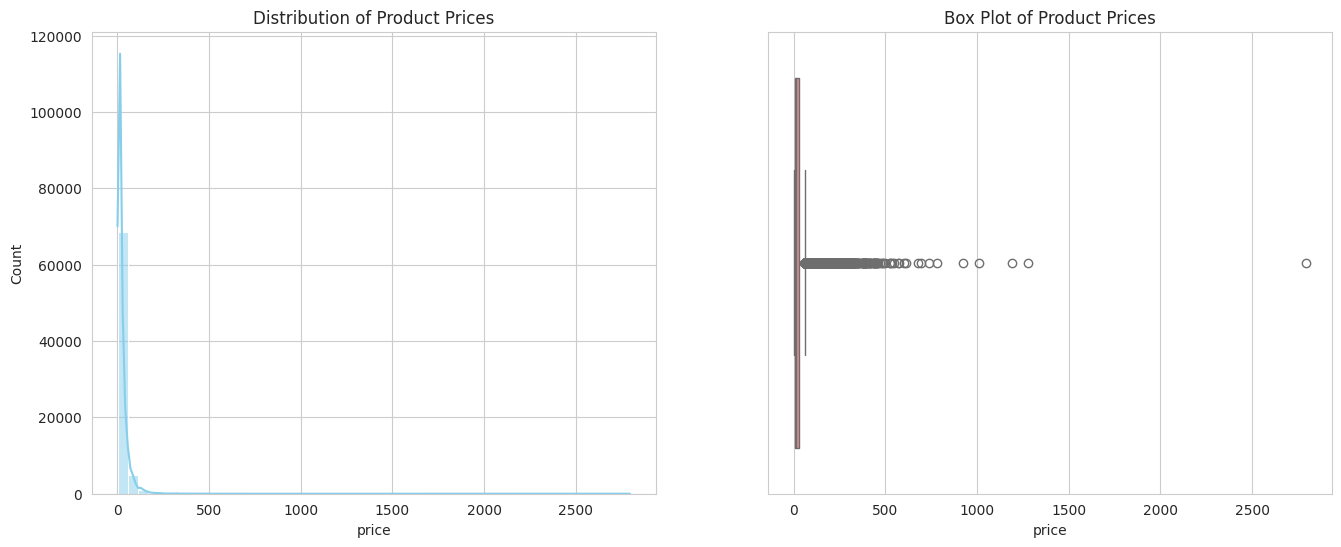


Descriptive Statistics:
count    75000.000000
mean        23.647654
std         33.376932
min          0.130000
25%          6.795000
50%         14.000000
75%         28.625000
max       2796.000000
Name: price, dtype: float64


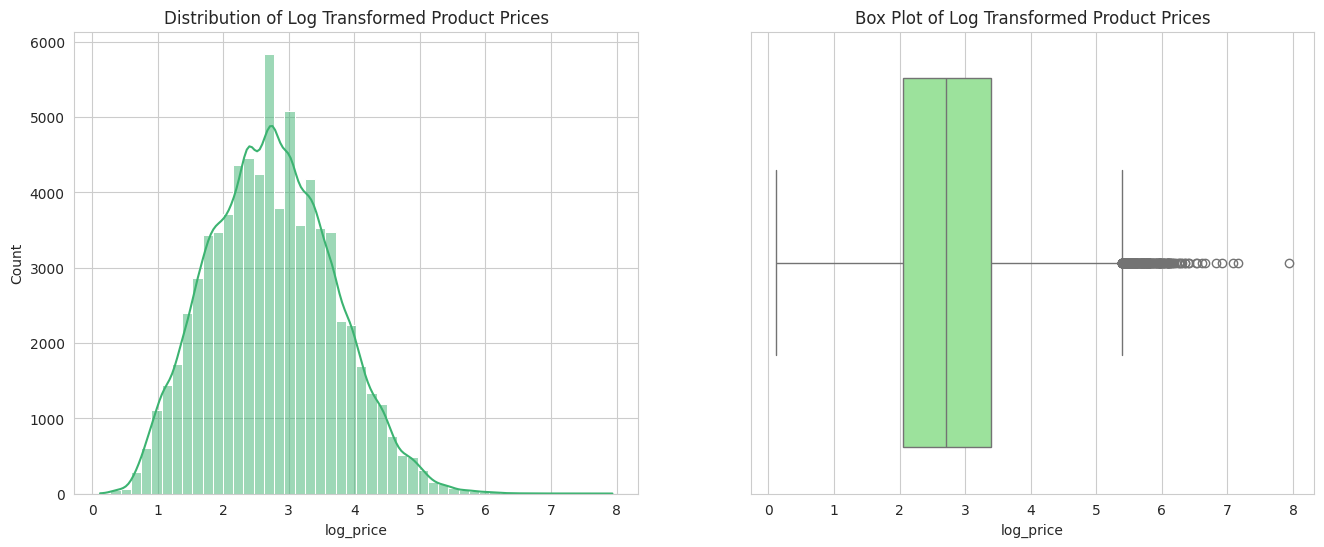


Descriptive Statistics for Log Transformed Price:
count    75000.000000
mean         2.739217
std          0.942032
min          0.122218
25%          2.053483
50%          2.708050
75%          3.388619
max          7.936303
Name: log_price, dtype: float64


In [2]:
# --- 3️⃣  Basic Price Distribution ---
sns.set_style("whitegrid")
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)

sns.histplot(df['price'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Product Prices')

plt.subplot(1,2,2)
sns.boxplot(x=df['price'], color='lightcoral')
plt.title('Box Plot of Product Prices')
plt.show()

print("\nDescriptive Statistics:")
print(df['price'].describe())

# Add a new column 'log_price' with the natural log of the 'price'
df['log_price'] = np.log1p(df['price'])

# Set the visual style for the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots, with a specified size
plt.figure(figsize=(16, 6))

# --- First Subplot: Histogram of Log Price ---
plt.subplot(1, 2, 1)
sns.histplot(df['log_price'], bins=50, kde=True, color='mediumseagreen')
plt.title('Distribution of Log Transformed Product Prices')

# --- Second Subplot: Box Plot of Log Price ---
plt.subplot(1, 2, 2)
sns.boxplot(x=df['log_price'], color='lightgreen')
plt.title('Box Plot of Log Transformed Product Prices')

# Display the plots
plt.show()

# --- Descriptive Statistics for Log Price ---
print("\nDescriptive Statistics for Log Transformed Price:")
print(df['log_price'].describe())




Price cap set at: $183.70
Removed 375 outliers (top 0.5% of prices).
DataFrame size changed from 75000 to 74625 rows.


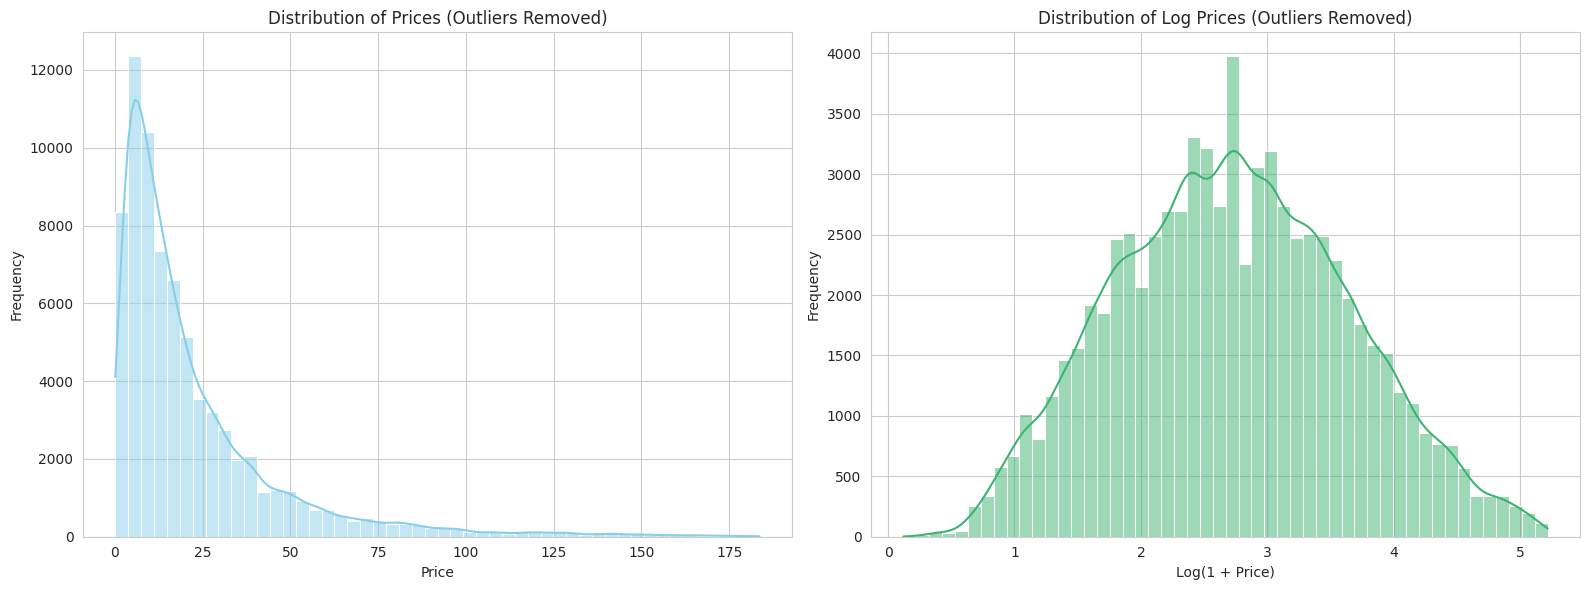


Descriptive Statistics for Prices (Outliers Removed):
count    74625.000000
mean        22.331795
std         24.608906
min          0.130000
25%          6.780000
50%         13.990000
75%         28.180000
max        183.700000
Name: price, dtype: float64

Descriptive Statistics for Log Prices (Outliers Removed):
count    74625.000000
mean         2.724962
std          0.922300
min          0.122218
25%          2.051556
50%          2.707383
75%          3.373484
max          5.218733
Name: log_price, dtype: float64


In [3]:
OUTLIER_THRESHOLD = 0.995
price_cap = df['price'].quantile(OUTLIER_THRESHOLD)
df_no_outliers = df[df['price'] <= price_cap].copy()

print(f"Price cap set at: ${price_cap:.2f}")
print(f"Removed {len(df) - len(df_no_outliers)} outliers (top {100 - OUTLIER_THRESHOLD*100}% of prices).")
print(f"DataFrame size changed from {len(df)} to {len(df_no_outliers)} rows.")


# --- 2. Visualize Distributions (Histograms Only) ---

sns.set_style("whitegrid")
plt.figure(figsize=(16, 6))

# Subplot 1: Distribution of standard prices after outlier removal
plt.subplot(1, 2, 1)
sns.histplot(df_no_outliers['price'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Prices (Outliers Removed)')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Subplot 2: Distribution of log prices after outlier removal
plt.subplot(1, 2, 2)
sns.histplot(df_no_outliers['log_price'], bins=50, kde=True, color='mediumseagreen')
plt.title('Distribution of Log Prices (Outliers Removed)')
plt.xlabel('Log(1 + Price)')
plt.ylabel('Frequency')

plt.tight_layout() # Adjusts plot to prevent labels from overlapping
plt.show()


# --- 3. Display Descriptive Statistics for the Cleaned Data ---

print("\nDescriptive Statistics for Prices (Outliers Removed):")
print(df_no_outliers['price'].describe())

print("\nDescriptive Statistics for Log Prices (Outliers Removed):")
print(df_no_outliers['log_price'].describe())

In [4]:
# 1. Convert to lowercase first (still a good practice)
df_no_outliers['catalog_content_lower'] = df_no_outliers['catalog_content'].str.lower()

# 2. Extract the second-to-last line
# First, split by newline to get a list of lines
lines = df_no_outliers['catalog_content_lower'].str.split('\n')

# Then, select the second-to-last items directly to get a string
last_line = lines.str[-2]
second_last_line=lines.str[-3]
print("----------- Last Lines Extracted -----------")
print("\n" + "="*50 + "\n")


# 3. Clean the last line to isolate the unit
# We replace 'unit:' with an empty string and then strip any whitespace
cleaned_units = last_line.str.replace('unit:', '').str.strip()
cleaned_values = second_last_line.str.replace('value:', '').str.strip()
# Convert the 'cleaned_values' Series from strings to numbers
# If any value can't be converted, it will become NaN (Not a Number)
cleaned_values_numeric = pd.to_numeric(cleaned_values, errors='coerce')

# 4. Get the frequency count
unit_frequencies = cleaned_units.value_counts()
print("----------- Final Frequency Count -----------")
#print(unit_frequencies)
print(cleaned_units[:5])
print(cleaned_values[:5])

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


# 1. Convert to lowercase for the test data
df_test['catalog_content_lower'] = df_test['catalog_content'].str.lower()

# 2. Extract the second-to-last line for the test data
# First, split by newline to get a list of lines
lines_test = df_test['catalog_content_lower'].str.split('\n')

# Then, select the relevant lines directly
last_line_test = lines_test.str[-2]
second_last_line_test = lines_test.str[-3]
print("----------- Test Data: Lines Extracted -----------")
print("\n" + "="*50 + "\n")

# 3. Clean the lines to isolate the unit and value
# We replace the prefix with an empty string and then strip any whitespace
cleaned_units_test = last_line_test.str.replace('unit:', '').str.strip()
cleaned_values_test = second_last_line_test.str.replace('value:', '').str.strip()

# Convert the 'cleaned_values_test' Series from strings to numbers
# If any value can't be converted, it will become NaN (Not a Number)
cleaned_values_numeric_test = pd.to_numeric(cleaned_values_test, errors='coerce')

# 4. Get the frequency count and display results for the test data
unit_frequencies_test = cleaned_units_test.value_counts()
print("----------- Test Data: Final Frequency Count & Preview -----------")
# print(unit_frequencies_test) # Uncomment to see the full frequency count
print("First 5 Cleaned Units (Test):")
print(cleaned_units_test[:5])
print("\nFirst 5 Cleaned Values (Test):")
print(cleaned_values_test[:5])

----------- Last Lines Extracted -----------


----------- Final Frequency Count -----------
0    fl oz
1    ounce
2    ounce
3    ounce
4    count
Name: catalog_content_lower, dtype: object
0     72.0
1     32.0
2     11.4
3    11.25
4     12.0
Name: catalog_content_lower, dtype: object
----------- Test Data: Lines Extracted -----------


----------- Test Data: Final Frequency Count & Preview -----------
First 5 Cleaned Units (Test):
0    ounce
1    fl oz
2    ounce
3    count
4    fl oz
Name: catalog_content_lower, dtype: object

First 5 Cleaned Values (Test):
0    10.5
1     2.0
2    32.0
3     2.0
4    32.0
Name: catalog_content_lower, dtype: object


In [5]:
# --- 5️⃣  Quantity & Unit Extraction ---
UNIT_MAP = {
    'ounce': 'oz','ounces': 'oz','oz': 'oz','fl oz': 'floz','fl. oz': 'floz','fluid ounce':'floz',
    'fluid ounces':'floz','pound': 'lb','lb': 'lb','g': 'g', 'gram':'g','kg': 'kg','ml': 'ml',
    'millilitre':'ml','l': 'l','litre':'l','liters':'l','ct': 'count','count': 'count','each':'count',
    'packs':'count','pack':'count'
}

# 1. Use the .map() method to convert the entire column of units
# This applies the UNIT_MAP dictionary to each unit in the 'cleaned_units' Series.
standard_units_series = cleaned_units.map(UNIT_MAP)

# (Optional) Handle any units that were not in your map. They will become NaN (Not a Number).
# 'none' was already an error classification in the actual data
standard_units_series = standard_units_series.fillna('none')


# 2. Create the new DataFrame and assign the new features
df_processed = df_no_outliers.copy()

# Assign the cleaned values and the new standardized units as new columns
df_processed['total_quantity'] = cleaned_values_numeric
df_processed['standard_unit'] = standard_units_series


print("\nFeature extraction complete.")
display(df_processed.head())


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


# --- 5️⃣  Quantity & Unit Extraction (Test Data) ---

# 1. Use the .map() method to standardize units for the test data
# The same UNIT_MAP is applied to the 'cleaned_units_test' Series.
standard_units_series_test = cleaned_units_test.map(UNIT_MAP)

# Handle any units that were not in the map for the test data.
standard_units_series_test = standard_units_series_test.fillna('none')

# 2. Create the new DataFrame for test data and assign the new features
df_processed_test = df_test.copy()

# Assign the cleaned values and the new standardized units as new columns
df_processed_test['total_quantity'] = cleaned_values_numeric_test
df_processed_test['standard_unit'] = standard_units_series_test

print("\nFeature extraction for test data complete.")
display(df_processed_test.head())


Feature extraction complete.


,sample_id,catalog_content,image_link,price,log_price,catalog_content_lower,total_quantity,standard_unit
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",https://m.media-amazon.com/images/I/51mo8htwTH...,4.89,1.773256,"item name: la victoria green taco sauce mild, ...",72.00,floz
1,198967,"Item Name: Salerno Cookies, The Original Butte...",https://m.media-amazon.com/images/I/71YtriIHAA...,13.12,2.647592,"item name: salerno cookies, the original butte...",32.00,oz
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",https://m.media-amazon.com/images/I/51+PFEe-w-...,1.97,1.088562,"item name: bear creek hearty soup bowl, creamy...",11.40,oz
3,55858,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,https://m.media-amazon.com/images/I/41mu0HAToD...,30.34,3.444895,item name: judee’s blue cheese powder 11.25 oz...,11.25,oz
4,292686,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",https://m.media-amazon.com/images/I/41sA037+Qv...,66.49,4.211979,"item name: kedem sherry cooking wine, 12.7 oun...",12.00,count



Feature extraction for test data complete.


,sample_id,catalog_content,image_link,catalog_content_lower,total_quantity,standard_unit
0,100179,Item Name: Rani 14-Spice Eshamaya's Mango Chut...,https://m.media-amazon.com/images/I/71hoAn78AW...,item name: rani 14-spice eshamaya's mango chut...,10.5,oz
1,245611,Item Name: Natural MILK TEA Flavoring extract ...,https://m.media-amazon.com/images/I/61ex8NHCIj...,item name: natural milk tea flavoring extract ...,2.0,floz
2,146263,Item Name: Honey Filled Hard Candy - Bulk Pack...,https://m.media-amazon.com/images/I/61KCM61J8e...,item name: honey filled hard candy - bulk pack...,32.0,oz
3,95658,Item Name: Vlasic Snack'mm's Kosher Dill 16 Oz...,https://m.media-amazon.com/images/I/51Ex6uOH7y...,item name: vlasic snack'mm's kosher dill 16 oz...,2.0,count
4,36806,"Item Name: McCormick Culinary Vanilla Extract,...",https://m.media-amazon.com/images/I/71QYlrOMoS...,"item name: mccormick culinary vanilla extract,...",32.0,floz


In [6]:
# --- 6️⃣  Fill Missing Values (Training Data) ---
df_final = df_processed.copy()

# Drop the image_link column if it exists, as it's not needed for analysis
if 'image_link' in df_final.columns:
    df_final.drop('image_link', axis=1, inplace=True)

# Calculate the median from the training data ONLY. This will be used for both sets.
###WHY???!!?!?!?!??!
training_quantity_median = df_final['total_quantity'].median()
###WHY!?!???!?!?!?!?

# Fill missing numerical values with the calculated median
df_final['total_quantity'].fillna(training_quantity_median, inplace=True)

# Fill missing categorical values with a placeholder string 'unknown'
df_final['standard_unit'].fillna('none', inplace=True)

print("\n✅ Training DataFrame cleaned and ready.")
display(df_final.info())


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


# --- 6️⃣  Fill Missing Values (Test Data) ---
df_final_test = df_processed_test.copy()

# Drop the image_link column if it exists
if 'image_link' in df_final_test.columns:
    df_final_test.drop('image_link', axis=1, inplace=True)

# Fill missing numerical values using the MEDIAN CALCULATED FROM THE TRAINING DATA
# This is crucial to prevent data leakage from the test set into the "training" process.
df_final_test['total_quantity'].fillna(training_quantity_median, inplace=True)

# Fill missing categorical values with the same placeholder
df_final_test['standard_unit'].fillna('none', inplace=True)

print("\n✅ Test DataFrame cleaned and ready.")
display(df_final_test.info())


✅ Training DataFrame cleaned and ready.
<class 'pandas.core.frame.DataFrame'>
Index: 74625 entries, 0 to 74999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sample_id              74625 non-null  int64  
 1   catalog_content        74625 non-null  object 
 2   price                  74625 non-null  float64
 3   log_price              74625 non-null  float64
 4   catalog_content_lower  74625 non-null  object 
 5   total_quantity         74625 non-null  float64
 6   standard_unit          74625 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 4.6+ MB


None


✅ Test DataFrame cleaned and ready.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sample_id              75000 non-null  int64  
 1   catalog_content        75000 non-null  object 
 2   catalog_content_lower  75000 non-null  object 
 3   total_quantity         75000 non-null  float64
 4   standard_unit          75000 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 2.9+ MB


None

In [7]:
# --- 7️⃣  Prepare Features for Modeling (Training Data) ---

# Apply one-hot encoding to the categorical 'standard_unit' column
df_final = pd.get_dummies(df_final, columns=['standard_unit'], prefix='unit')

# Create the final feature set by dropping non-feature columns and the target variable
structured_features = df_final.drop(columns=['sample_id', 'catalog_content_lower', 'catalog_content', 'price', 'log_price'])

print("✅ Training features prepared.")
print("Training feature shape:", structured_features.shape)
display(structured_features.head())


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


# --- 7️⃣  Prepare Features for Modeling (Test Data) ---

# Apply one-hot encoding to the test data
df_final_test = pd.get_dummies(df_final_test, columns=['standard_unit'], prefix='unit')

# --- IMPORTANT: Align Columns ---
# Ensure the test set has the exact same columns as the training set
# This handles cases where some units might appear in training but not in test, or vice-versa.
# 'reindex' will add missing columns (and fill with 0) and drop extra columns.
#structured_features_test, _ = structured_features.align(df_final_test, join='right', axis=1, fill_value=0)


structured_features_test = df_final_test.drop(columns=['sample_id', 'catalog_content_lower', 'catalog_content'])


print("\n✅ Test features prepared and aligned with training set.")
print("Test feature shape:", structured_features_test.shape)
display(structured_features_test.head())

✅ Training features prepared.
Training feature shape: (74625, 10)


,total_quantity,unit_count,unit_floz,unit_g,unit_kg,unit_l,unit_lb,unit_ml,unit_none,unit_oz
0,72.00,False,True,False,False,False,False,False,False,False
1,32.00,False,False,False,False,False,False,False,False,True
2,11.40,False,False,False,False,False,False,False,False,True
3,11.25,False,False,False,False,False,False,False,False,True
4,12.00,True,False,False,False,False,False,False,False,False



✅ Test features prepared and aligned with training set.
Test feature shape: (75000, 10)


,total_quantity,unit_count,unit_floz,unit_g,unit_kg,unit_l,unit_lb,unit_ml,unit_none,unit_oz
0,10.5,False,False,False,False,False,False,False,False,True
1,2.0,False,True,False,False,False,False,False,False,False
2,32.0,False,False,False,False,False,False,False,False,True
3,2.0,True,False,False,False,False,False,False,False,False
4,32.0,False,True,False,False,False,False,False,False,False


In [8]:
import os
import torch
import numpy as np
from sentence_transformers import SentenceTransformer
import pandas as pd # Make sure pandas is imported

# This script assumes your 'df_final' DataFrame is already loaded in your environment.

# --- 1. DEFINE PATHS ---

# Path to your locally saved, fine-tuned model folder.
# This MUST match the 'SAVE_PATH' from your training script.
FINE_TUNED_MODEL_PATH = './fine_tuned_bge_log_price_model_3_epochs'

# Define a new filename for these superior embeddings to avoid overwriting your old ones.
EMBEDDINGS_FILE = 'embeddings_finetuned_train_3_epochs.npy'

# --- 2. CHECK IF EMBEDDINGS ARE ALREADY COMPUTED ---

if os.path.exists(EMBEDDINGS_FILE):
    # If the file exists, load it directly
    print(f"Loading pre-computed fine-tuned embeddings from {EMBEDDINGS_FILE}...")
    embeddings = np.load(EMBEDDINGS_FILE)

else:
    # If the file does NOT exist, generate them using your new model
    print("Fine-tuned embeddings not found. Generating new ones...")

    # Set the device to use (GPU if available)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # --- THE CRUCIAL CHANGE IS HERE ---
    # Load the specialized transformer that YOU fine-tuned from your local disk.
    # It no longer downloads the generic model from the internet.
    print(f"Loading your specialized model from: {FINE_TUNED_MODEL_PATH}")
    model = SentenceTransformer(FINE_TUNED_MODEL_PATH, device=device)

    # Get the text data from your DataFrame
    texts = df_final['catalog_content_lower'].astype(str).tolist()

    # Generate the embeddings with your superior, price-aware model
    print("\nGenerating price-aware embeddings...")
    embeddings = model.encode(texts, show_progress_bar=True, batch_size=64)

    # --- Save the newly generated embeddings for future use ---
    print(f"Saving fine-tuned embeddings to {EMBEDDINGS_FILE}...")
    np.save(EMBEDDINGS_FILE, embeddings)

print(f"\n✅ Success! Your powerful new embeddings are ready in the '{EMBEDDINGS_FILE}' file.")
print("You can now use these as features for your LGBM model.")


# --- 3. COMBINE FEATURES (This part is the same as before) ---
# Now, 'embeddings' is ready, either from loading or from generating
# Note: Ensure 'structured_features' is a numpy array for concatenation
structured_features_np = structured_features.values

X = np.concatenate([structured_features_np, embeddings], axis=1)
y = df_final['log_price'].values

print(f"\nFeature matrix shape: {X.shape}, Target shape: {y.shape}")
print(X[:1])
print(y[:5])

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# --- 1. DEFINE PATHS ---

# Path to your locally saved, fine-tuned model folder.
# This MUST be the same model used for the training data.
FINE_TUNED_MODEL_PATH = './fine_tuned_bge_log_price_model_3_epochs'

# Define a new filename for the TEST embeddings to keep them separate.
TEST_EMBEDDINGS_FILE = 'embeddings_finetuned_test_3_epochs.npy'

# --- 2. CHECK IF TEST EMBEDDINGS ARE ALREADY COMPUTED ---

if os.path.exists(TEST_EMBEDDINGS_FILE):
    # If the file exists, load it directly
    print(f"Loading pre-computed fine-tuned test embeddings from {TEST_EMBEDDINGS_FILE}...")
    test_embeddings = np.load(TEST_EMBEDDINGS_FILE)

else:
    # If the file does NOT exist, generate them using your fine-tuned model
    print("Fine-tuned test embeddings not found. Generating new ones...")

    # Set the device to use (GPU if available)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # --- Load the EXACT SAME fine-tuned model ---
    # This ensures that test data is transformed in the same way as training data.
    print(f"Loading your specialized model from: {FINE_TUNED_MODEL_PATH}")
    model = SentenceTransformer(FINE_TUNED_MODEL_PATH, device=device)


    # Get the text data from your TEST DataFrame
    # Make sure the column name 'catalog_content_lower' is correct for your test set.
    test_texts = df_test['catalog_content_lower'].astype(str).tolist()

    # Generate the embeddings with your superior, price-aware model
    print("\nGenerating price-aware embeddings for the test set...")
    test_embeddings = model.encode(test_texts, show_progress_bar=True, batch_size=64)

    # --- Save the newly generated test embeddings for future use ---
    print(f"Saving fine-tuned test embeddings to {TEST_EMBEDDINGS_FILE}...")
    np.save(TEST_EMBEDDINGS_FILE, test_embeddings)

print(f"\n✅ Success! Your test embeddings are ready in the '{TEST_EMBEDDINGS_FILE}' file.")
print("You can now use these features to make predictions with your trained LGBM model.")


# --- 3. COMBINE FEATURES FOR THE TEST SET ---
# Now, 'test_embeddings' is ready, either from loading or from generating
# Note: Ensure 'structured_features_test' is a numpy array for concatenation
structured_features_test_np = structured_features_test.values

# Create the final feature matrix for the test set
X_test = np.concatenate([structured_features_test_np, test_embeddings], axis=1)

print(f"\nTest feature matrix shape: {X_test.shape}")

# You can now use X_test to make predictions:
# predictions = lgbm_model.predict(X_test)




Loading pre-computed fine-tuned embeddings from embeddings_finetuned_train_3_epochs.npy...



✅ Success! Your powerful new embeddings are ready in the 'embeddings_finetuned_train_3_epochs.npy' file.
You can now use these as features for your LGBM model.

Feature matrix shape: (74625, 1034), Target shape: (74625,)
[[72.0 False True ... 0.004700962919741869 -0.014955760911107063
  -0.03363465145230293]]
[1.773256   2.64759223 1.08856195 3.44489524 4.21197944]
Loading pre-computed fine-tuned test embeddings from embeddings_finetuned_test_3_epochs.npy...

✅ Success! Your test embeddings are ready in the 'embeddings_finetuned_test_3_epochs.npy' file.
You can now use these features to make predictions with your trained LGBM model.

Test feature matrix shape: (75000, 1034)


In [9]:
print(structured_features_test.head())

   total_quantity  unit_count  unit_floz  unit_g  unit_kg  unit_l  unit_lb  \
0            10.5       False      False   False    False   False    False   
1             2.0       False       True   False    False   False    False   
2            32.0       False      False   False    False   False    False   
3             2.0        True      False   False    False   False    False   
4            32.0       False       True   False    False   False    False   

   unit_ml  unit_none  unit_oz  
0    False      False     True  
1    False      False    False  
2    False      False     True  
3    False      False    False  
4    False      False    False  


Training LightGBM model...
Training complete.

✅ Submission file created successfully. Preview:


,sample_id,price
0,100179,13.855082
1,245611,11.295630
2,146263,17.092838
3,95658,6.657615
4,36806,39.313202



✅ Validation SMAPE: 43.0056%
✅ Validation MAPE:  61.2559%
✅ Validation R²:    0.6100
✅ Validation MAE:   8.58
✅ Validation MSE:   237.21
✅ Validation RMSE:  15.40


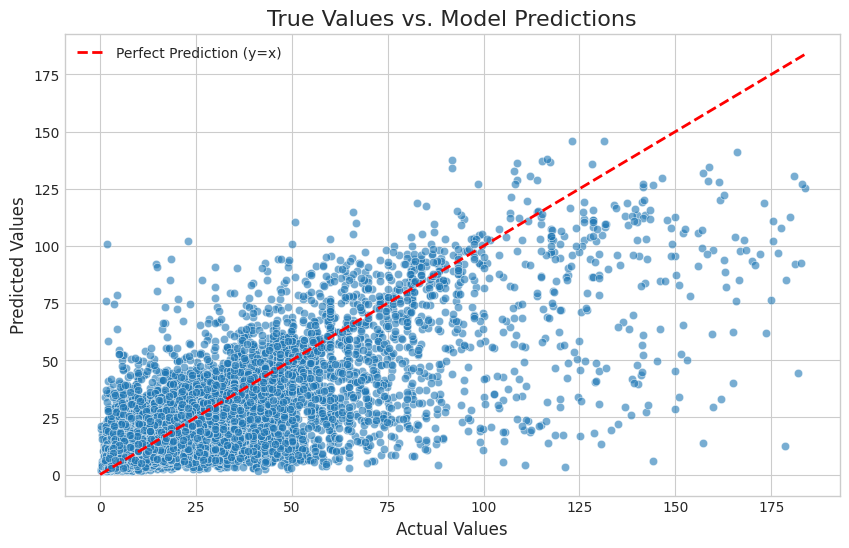

In [12]:
# --- 9️⃣  Train LightGBM ---
def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    num = np.abs(y_pred - y_true)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(np.where(denom==0, 0, num/denom)) * 100

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

lgbm = lgb.LGBMRegressor(
    objective='regression_l2',
    n_estimators=3000,
    learning_rate=0.06,
    reg_alpha=100,
    random_state=42,
    verbose=-1 # Changed to -1 to keep the output clean
)

print("Training LightGBM model...")
lgbm.fit(X_train, y_train)
print("Training complete.")

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
preds_log_test=lgbm.predict(X_test)
preds_actual_test=np.expm1(preds_log_test)


# 3. Create the submission DataFrame
# This combines the 'sample_id' from your test dataframe with the newly generated predictions.
submission_df = pd.DataFrame({
    'sample_id': df_test['sample_id'],
    'price': preds_actual_test
})

# 4. Display the first few rows of the final submission file
print("\n✅ Submission file created successfully. Preview:")
display(submission_df.head())

submission_df.to_csv('submission.csv', index=False)
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%



# --- Prediction & Inverse Transformation ---

# 1. Predict on the log scale
preds_log = lgbm.predict(X_val)

# 2. Convert predictions AND true validation values back to the original price scale
preds_actual = np.expm1(preds_log)
y_val_actual = np.expm1(y_val)

# --- MODIFIED PART: Calculate All Metrics & Visualize ---

# 1. Calculate all scores on the actual price scale
smape_score = smape(y_val_actual, preds_actual)
mape_score = mape(y_val_actual, preds_actual)
r2 = r2_score(y_val_actual, preds_actual)
mae = mean_absolute_error(y_val_actual, preds_actual)
mse = mean_squared_error(y_val_actual, preds_actual)
rmse = np.sqrt(mse)

# 2. Print the scores
print("\n===================================")
print(f"✅ Validation SMAPE: {smape_score:.4f}%")
print(f"✅ Validation MAPE:  {mape_score:.4f}%")
print(f"✅ Validation R²:    {r2:.4f}")
print(f"✅ Validation MAE:   {mae:.2f}")
print(f"✅ Validation MSE:   {mse:.2f}")
print(f"✅ Validation RMSE:  {rmse:.2f}")
print("===================================")


# 3. Create the graph of errors
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot of True vs. Predicted values
sns.scatterplot(x=y_val_actual, y=preds_actual, alpha=0.6, ax=ax)

# Line for perfect predictions (y=x)
line_max = max(y_val_actual.max(), preds_actual.max())
ax.plot([0, line_max], [0, line_max], color='red', linestyle='--', lw=2, label='Perfect Prediction (y=x)')

ax.set_title('True Values vs. Model Predictions', fontsize=16)
ax.set_xlabel('Actual Values', fontsize=12)
ax.set_ylabel('Predicted Values', fontsize=12)
ax.legend()
plt.show()



In [11]:
print(X[:1])
print(y[:10])

[[72.0 False True ... 0.004700962919741869 -0.014955760911107063
  -0.03363465145230293]]
[1.773256   2.64759223 1.08856195 3.44489524 4.21197944 2.97041447
 1.94448056 4.55387689 3.60386608 3.49042852]
